In [1]:
!pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver

import matplotlib.pyplot as plt

  Cloning git://github.com/StochSS/sciope.git (to revision master) to /tmp/pip-req-build-29qugehx


  Created wheel for sciope: filename=sciope-0.4-py3-none-any.whl size=89110 sha256=9bb43804337a9287fd39521d6c23afa88eae6aca8a14ae9059846a6f1136eeec
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7lzxjpw/wheels/4c/8a/1b/24dbc19bb62d6c1873cfb5b32facf15dc677dce8caa60a578b
Successfully built sciope


# devils_v1.0
- Need to validate timespan

In [2]:
class Devilsv101(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression="1"))
        self.add_parameter(Parameter(name="K", expression="217"))
        self.add_parameter(Parameter(name="ds", expression="0.22"))
        self.add_parameter(Parameter(name="dI", expression="1.28"))
        self.add_parameter(Parameter(name="L", expression=".75"))
        # self.add_parameter(Parameter(name="sigma", expression="0.5"))
        # self.add_parameter(Parameter(name="p", expression="0.6"))
        self.add_parameter(Parameter(name="k0", expression="4"))
        # self.add_parameter(Parameter(name="vf", expression="1"))
        # self.add_parameter(Parameter(name="vt", expression="0"))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=0, mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        # self.add_species(Species(name="W", initial_value=0, mode="discrete"))
#         self.add_species(Species(name="R", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
#         self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1}, propensity_function="r*S*(1-S/K)"))
#         self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1}, rate=self.listOfParameters['r']))
#         self.add_reaction(Reaction(name='infect', reactants={'S':1}, products={'I':1}, rate=self.listOfParameters['infection']))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1}, products={'E': 1}, propensity_function="k0*S*I/(S+E+I)"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        # self.add_reaction(Reaction(name="vaccine_failure", reactants={'W': 1}, products={'E': 1}, propensity_function="k0*sigma*W*I/(S+E+I+W+R)"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))
        # self.add_reaction(Reaction(name="death_W", reactants={'W': 1}, products={}, propensity_function="ds*W"))
#         self.add_reaction(Reaction(name="death_R", reactants={'Devils': 1, 'R': 1}, products={}, propensity_function="ds*R"))

        # # Event Triggers
        # vaccination_trig = EventTrigger(expression="t >= vt+vf", initial_value=False, persistent=False)

        # # Event Assignments
        # vaccination_assign_1 = EventAssignment(variable="vt", expression="vt+1")
        # vaccination_assign_2 = EventAssignment(variable="W", expression="W+(S*p)")
        # vaccination_assign_3 = EventAssignment(variable="S", expression="S*(1-p)")

        # # Events
        # self.add_event(Event(name="vaccination", trigger=vaccination_trig, assignments=[vaccination_assign_1, vaccination_assign_2, vaccination_assign_3], delay=None, priority="0", use_values_from_trigger_time=True))

        # Timespan
        self.timespan(np.arange(0, 8, 1)) # month data tspan
#         self.timespan(np.arange(0, 60, 1)) # month data tspan
#         self.timespan(np.arange(0, 21, 1)) # year data tspan

In [3]:
model = Devilsv101()
print(len(model.tspan))

8


# Model Inference

In [4]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

## Generate some fixed(observed) data based on default parameters of the model

In [5]:
import pandas as pd

# pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')
pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
devil_pop = np.array(pop_data['Population'].iloc[:].values)
init_devils_pop = devil_pop[0]
dftd_pop = .1*init_devils_pop

model.listOfSpecies['Devils'].initial_value = init_devils_pop
# model.listOfParameters['K'].initial_value = init_devils_pop

model.listOfSpecies['I'].initial_value = dftd_pop  # This will be overwritten by variables later
model.listOfSpecies['S'].initial_value = init_devils_pop - dftd_pop

# r_pop = init_devils_pop - init_dfdt_pop
# init_e_pop = 0
# init_s_pop = r_pop - init_e_pop
# model.listOfSpecies['S'].initial_value = init_s_pop
# model.listOfSpecies['E'].initial_value = init_e_pop

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
print(obs)
# print(obs)

[[[113.17829457 131.39534884 145.34883721 143.02325581  96.51162791
    65.50387597  51.9379845   48.0620155 ]]]


In [6]:
def configure_simulation():
    solver = ODECSolver(model=model)
    kwargs = {
        "solver":solver,
#         "number_of_trajectories":100,
#         "seed":None,
#         "tau_tol":0.03,
#         "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [7]:
kwargs = configure_simulation()

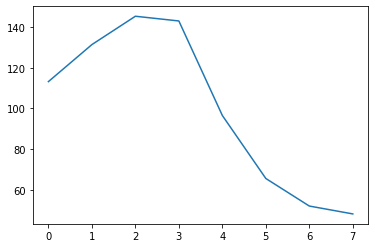

In [8]:
plt.plot(model.tspan, devil_pop)
# plt.plot(model.tspan, dfdt_pop)

In [9]:
results = model.run(solver=ODESolver)
results.plotplotly(included_species_list=['Devils'])

## Define prior distribution

In [10]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)
bound = np.log(bound)
# Set the bounds
bound = np.array(bound)
dmin = bound * 0.1
dmax = bound * 10.0

print(dmin)
print(dmax)
# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

['r', 'K', 'ds', 'dI', 'L', 'k0']
[1.0, 217.0, 0.22, 1.28, 0.75, 4.0]
[ 0.          0.53798974 -0.15141277  0.02468601 -0.02876821  0.13862944]
[  0.          53.79897354 -15.14127733   2.46860078  -2.87682072
  13.86294361]


In [11]:
# parameter_names = ['r',    'K',   'L',   'k0']
# lower_bounds =    [.002,   45000, .003,  .06]
# upper_bounds =    [.04,    75000, .04,   .7]
# uni_prior = uniform_prior.UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Define simulator

In [12]:
def set_model_parameters(params, model):
    # params - array, need to have the same order as model.listOfParameters
    for e, pname in enumerate(model.listOfParameters.keys()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# Here we use the GillesPy2 Solver
def simulator(params, model):
    print('testing params:\n', params)
    params = np.exp(params)
    model_update = set_model_parameters(params, model)

    res = model_update.run(**kwargs)
#     res = res.to_array()
#     tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
#     # should not contain timepoints
#     tot_res = tot_res[:, 1:, :]
    devils = res['Devils']
#     infected = res['I']

    return np.vstack([devils]).reshape(1, 1, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [13]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
ns = naive_squared.NaiveSquaredDistance()

## Start local cluster using dask client

In [14]:
c = Client()

## Start abc instance

In [15]:
abc = SMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute,
#                           distance_function=ns
                         )
# abc.compute_fixed_mean(1)

In [16]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [17]:
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=2)

<Client: 'tcp://127.0.0.1:40841' processes=2 threads=2, memory=4.00 GiB>
Determining initial population using 20
Starting epsilon = 689.6558169225507


In [18]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])
res[0]

{'accepted_samples': [array([ 0.        , 34.09465305, -1.90573627,  1.00305407, -0.05943626,
         10.66278411]),
  array([  0.        ,  31.39938057, -14.12331088,   1.54780417,
          -1.57171536,   8.54705491]),
  array([  0.        ,   2.87668151, -12.71408433,   1.58396861,
          -1.6196825 ,   0.7923992 ]),
  array([  0.        ,   6.71447046, -10.78255972,   2.26252448,
          -2.49478621,   0.5061301 ]),
  array([ 0.        , 40.86100135, -5.59195856,  0.66671019, -0.07417319,
         12.15940252]),
  array([  0.        ,  35.26909523, -10.3420454 ,   0.18879039,
          -2.2999538 ,  13.70900083]),
  array([  0.        ,   6.48819271, -14.03447931,   0.2019456 ,
          -1.57994505,   8.07905457]),
  array([  0.        ,   5.5740344 , -13.8296228 ,   0.84616342,
          -1.09289135,   7.69183732]),
  array([ 0.        , 28.35631071, -1.52080555,  0.61893584, -1.7826224 ,
          0.55104197]),
  array([ 0.        , 13.59809301, -9.64625484,  1.31776247, -

## Analysis

In [19]:
posterior = np.array(res[0]['accepted_samples'])

<ipython-input-20-f6209009ca72>:10: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

<ipython-input-20-f6209009ca72>:13: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



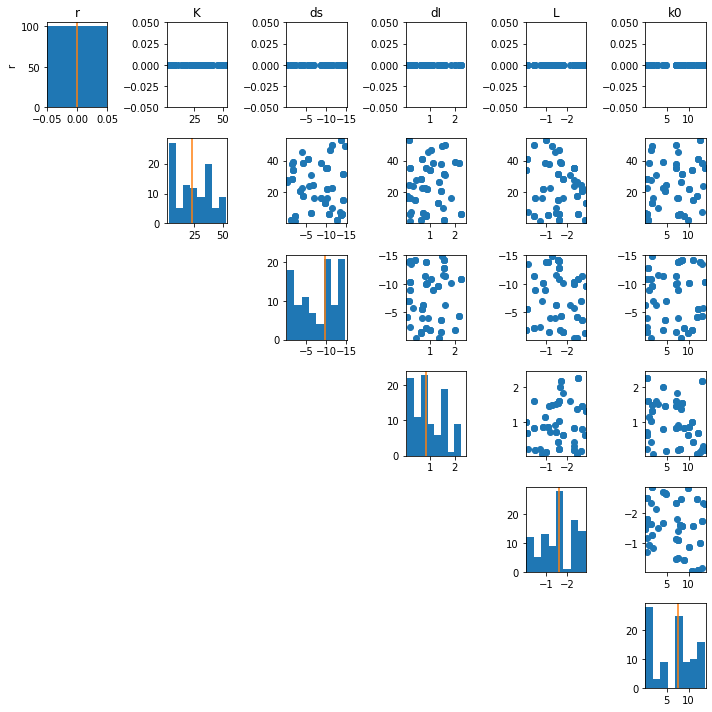

In [20]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(dmin[i], dmax[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(dmin[i], dmax[i])
                ax[i,j].set_xlim(dmin[j], dmax[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2)
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,1,:], color = 'C0', alpha = 0.02)
#     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
ax[0].plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Total Devil Population")
# ax[1].set_title("Infected")
ax[0].legend()
ax[1].legend()
fig.set_size_inches(12, 8)